In [1]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

In [2]:
DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*" # <- needs to be normalized
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*" # <- needs to be normalized
MODEL_NAME = "baseAE_orig"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"
NORMALIZE = True
SAVE_FILES = False

OUTPUT_MODEL_PATH = BASE_DIR + "Models/" + MODEL_NAME
TENSORBOARD_LOG_DIR = BASE_DIR + "tb_logs/" + MODEL_NAME
ACTIVATION_IMG_PATH = BASE_DIR + "activation_viz/" + MODEL_NAME
PATH_LIST = BASE_DIR + "Features/" + MODEL_NAME + "_filenames.pkl"
FEATURES_OUTPUT = BASE_DIR + "Features/" + MODEL_NAME + "_features.pkl"

# NUM_EPOCHS = 200

dust_labels = {0: "Dust", 1: "Hazy", 2: "No Dust"}

In [3]:
X_test_paths = pickle.load(file=open((PATH_LIST), 'rb'))
feature_list = pickle.load(file=open((FEATURES_OUTPUT), 'rb'))

In [4]:
num_images = len(X_test_paths)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  146
Number of features per image =  602112


In [5]:
# Use scikit-learn to find Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=50,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

In [6]:
# # Visually checking the images
# random_index = 2
# # KNN distance to all the neighbors with the reference image
# distances, indices = neighbors.kneighbors([feature_list[random_index]])

# sorted_idx = np.argsort(distances[0])        # sorting the index to get the image with min distance

# # Similar
# similar_idxs = sorted_idx[:10]
# print("Similar")
# print(distances[0][similar_idxs])         # index of interest
# print(indices[0][similar_idxs])           # the selected distances

# # Dissimilar
# dissimilar_idxs = sorted_idx[-1:-10:-1]
# print("Dissimilar")
# print(distances[0][dissimilar_idxs])         # index of interest
# print(indices[0][dissimilar_idxs])           # the selected distances

In [7]:
# # Normalize the image to plot
# def normalize(mat):
# #     valid_cells = np.invert(np.isnan(mat))
# #     normalized = np.subtract(mat, np.nanmin(mat), where=valid_cells) / (np.nanmax(mat) - np.nanmin(mat))
#     normalized = (mat - np.nanmin(mat)) / (np.nanmax(mat) - np.nanmin(mat))
#     return normalized

In [8]:
# # SIMILAR IMAGES

# img_idx = [random_index, *similar_idxs]
# filenames_selected = [X_test_paths[i] for i in img_idx]

# r = 2; c = 5
# fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r))

# # Query Image
# print("First image is the Query Image")
# for i, filename in enumerate(filenames_selected):
#     if NORMALIZE:
#         img = normalize(np.load(filename))
#     else:
#         img = np.load(filename)
#     print("img.shape:", img.shape, "min:", np.nanmin(img), "max:", np.nanmax(img))
        
#     try:
#         if (i/c == 0 and i%c == 0):
#             axs[int(i/c), i%c].set_title('Similarity rank %d - Query image' % (i))
#             for axis in ['top','bottom','left','right']:
#                 axs[int(i/c), i%c].spines[axis].set_linewidth(2)
#         else:
#             axs[int(i/c), i%c].set_title('Similarity rank %d' % (i))
            
#         axs[int(i/c), i%c].imshow(img, interpolation='lanczos')
#     except:
#         continue

# if SAVE_FILES:
#     fig.savefig(BASE_DIR + "Features/Images/" + MODEL_NAME + "_similar.png")

In [9]:
# # DISSIMILAR IMAGES

# img_idx = [random_index, *dissimilar_idxs]
# filenames_selected = [X_test_paths[i] for i in img_idx]

# r = 2; c = 5
# fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r))

# # Query Image
# print("First image is the Query Image")
# for i, filename in enumerate(filenames_selected):
#     if NORMALIZE:
#         img = normalize(np.load(filename))
#     else:
#         img = np.load(filename)
#     print("min:", np.nanmin(img), "max:", np.nanmax(img))
    
#     try:
#         if (i/c == 0 and i%c == 0):
#             axs[int(i/c), i%c].set_title('Dissimilarity rank %d - Query image' % (i))
#             for axis in ['top','bottom','left','right']:
#                 axs[int(i/c), i%c].spines[axis].set_linewidth(2)
#         else:
#             axs[int(i/c), i%c].set_title('Dissimilarity rank %d' % (i))
            
#         axs[int(i/c), i%c].imshow(img, interpolation='lanczos')
#     except:
#         continue

# if SAVE_FILES:
#     fig.savefig(BASE_DIR + "Features/Images/" + MODEL_NAME + "_dissimilar.png")

----------------------------------------------------------------------------------------------

In [10]:
# X_test_paths[0].split('/')[-1].split(".")[1]

In [11]:
# Helper function to get the classname
def classname(str):
    dust_gt = pickle.load(file=open(("/home/satyarth934/data/modis_data_products/MODIS_Dust_Events_2010_2020_h16v7.pkl"), mode = 'rb'))
    doy = str.split('/')[-1].split('.')[1][1:]
    return dust_gt[doy]
#     return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return dust_labels[classname(str)] + '/' + str.split('/')[-1].split(".")[1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(np.load(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        if SAVE_FILES:
            output_path = BASE_DIR + "Features/Images/" + MODEL_NAME + "_similar_%s_%s.pdf" % (filenames[i].split('/')[-1].split(".")[1], dust_labels[classname(filenames[i])])
            plt.savefig(output_path, format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

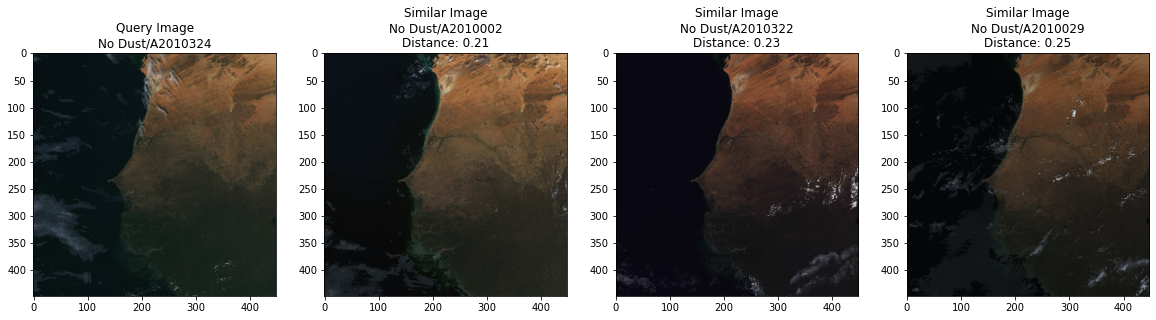

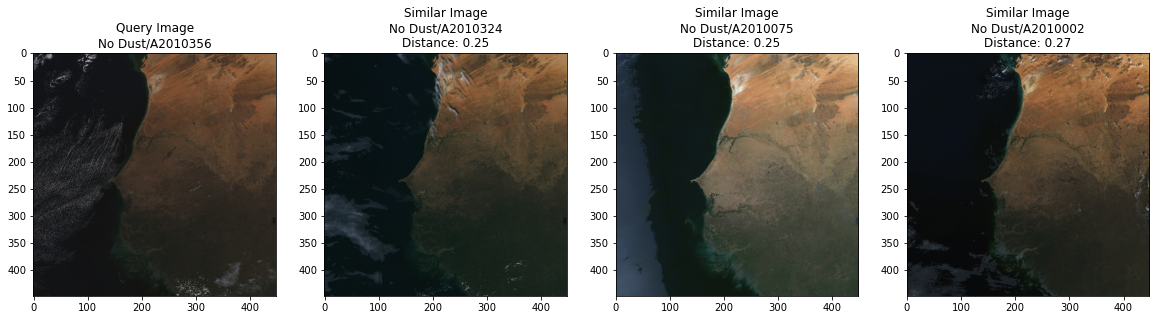

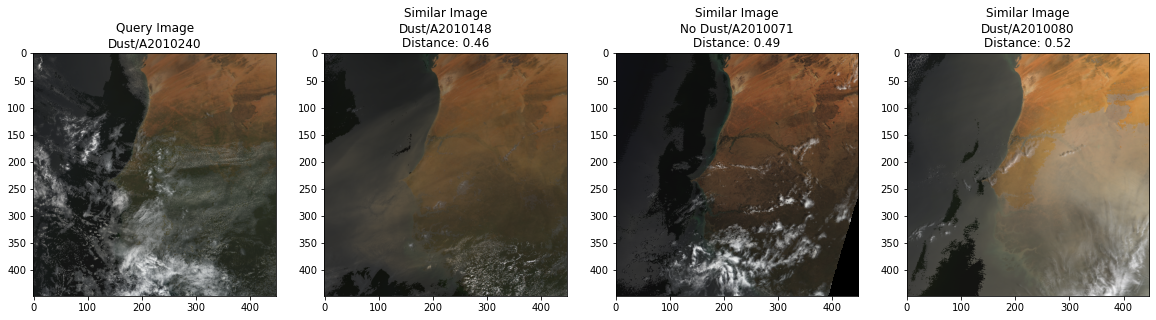

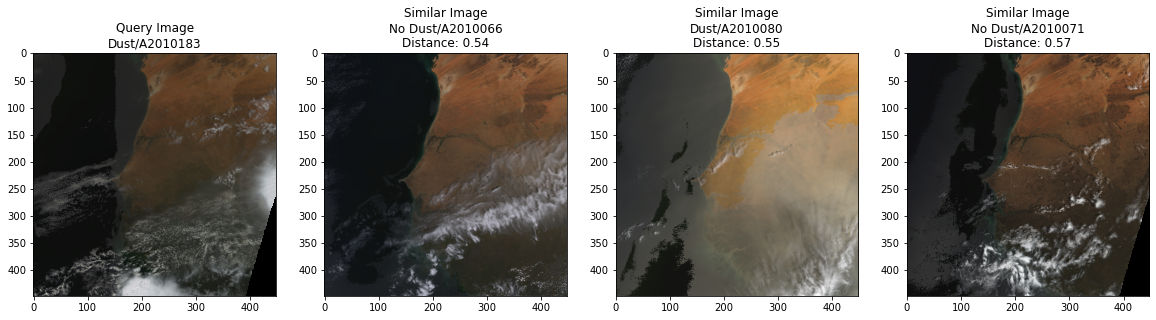

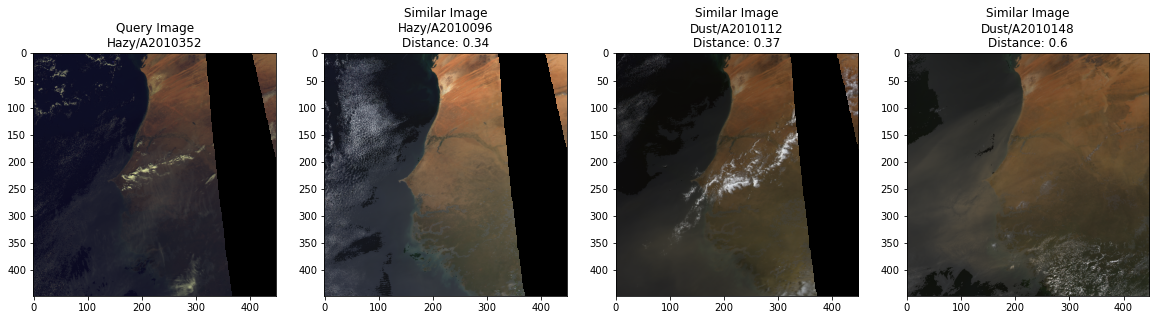

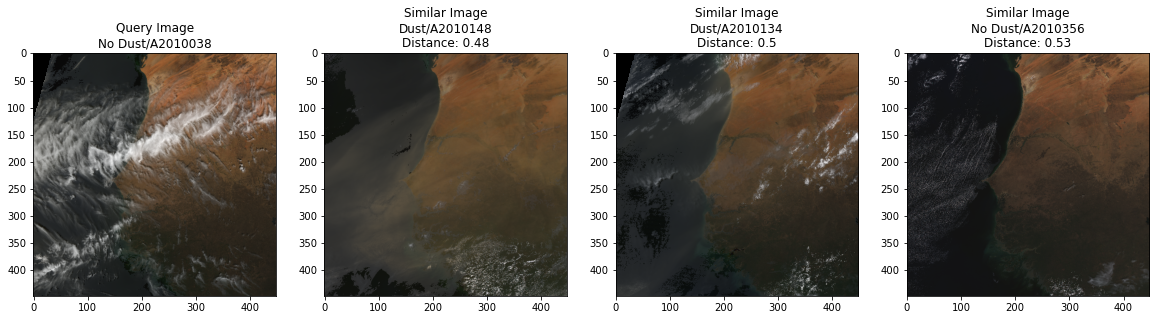

In [12]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [X_test_paths[random_image_index]] + [X_test_paths[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [13]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  0.7506219
Max distance between all photos:  1.4011542
Median distance among most similar photos:  0.5207888


In [14]:
selected_features = feature_list[:]
selected_class_ids = [classname(f) for f in X_test_paths[:]]
selected_filenames = X_test_paths[:]

In [15]:
import time
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 146 samples in 0.068s...
[t-SNE] Computed neighbors for 146 samples in 3.124s...
[t-SNE] Computed conditional probabilities for sample 146 / 146
[t-SNE] Mean sigma: 0.234385
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.392357
[t-SNE] KL divergence after 1000 iterations: 0.558288
t-SNE done! Time elapsed: 3.7978198528289795 seconds


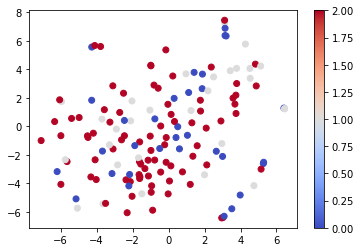

In [16]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()
# To save the plot in a high definition format i.e. PDF, uncomment the following line:
#plt.savefig('results/' + str(ADD_NAME_HERE)+'.pdf', format='pdf', dpi=1000)

In [17]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data


def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.fromarray(np.uint8(np.load(image_path)*255))
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [18]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

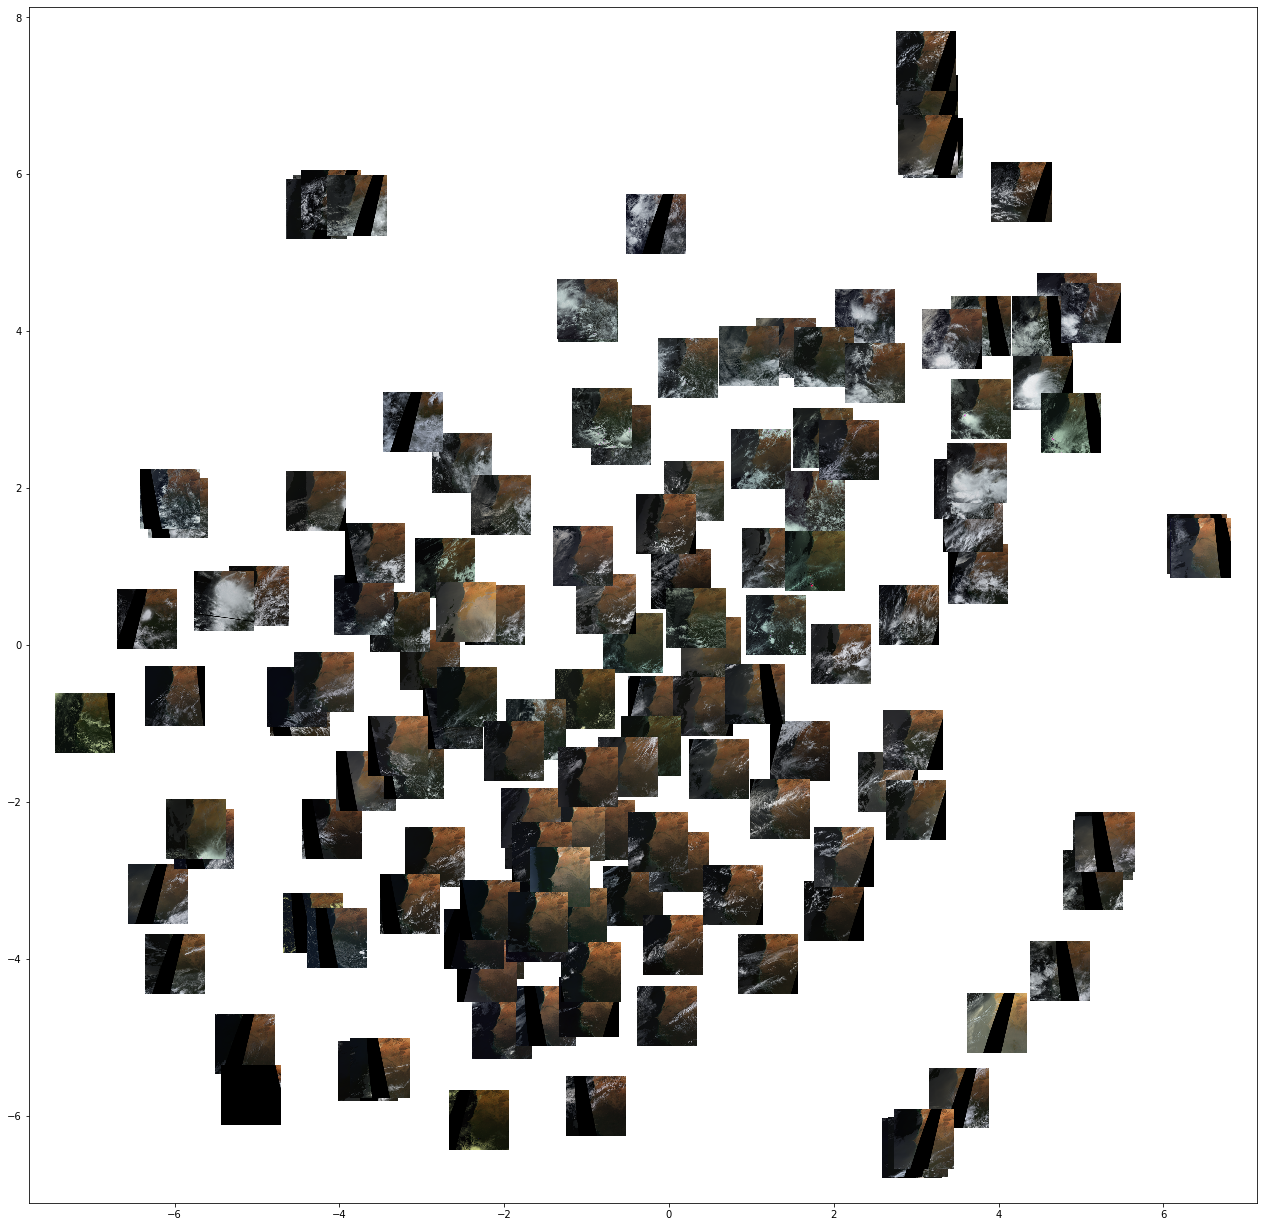

In [19]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [20]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()

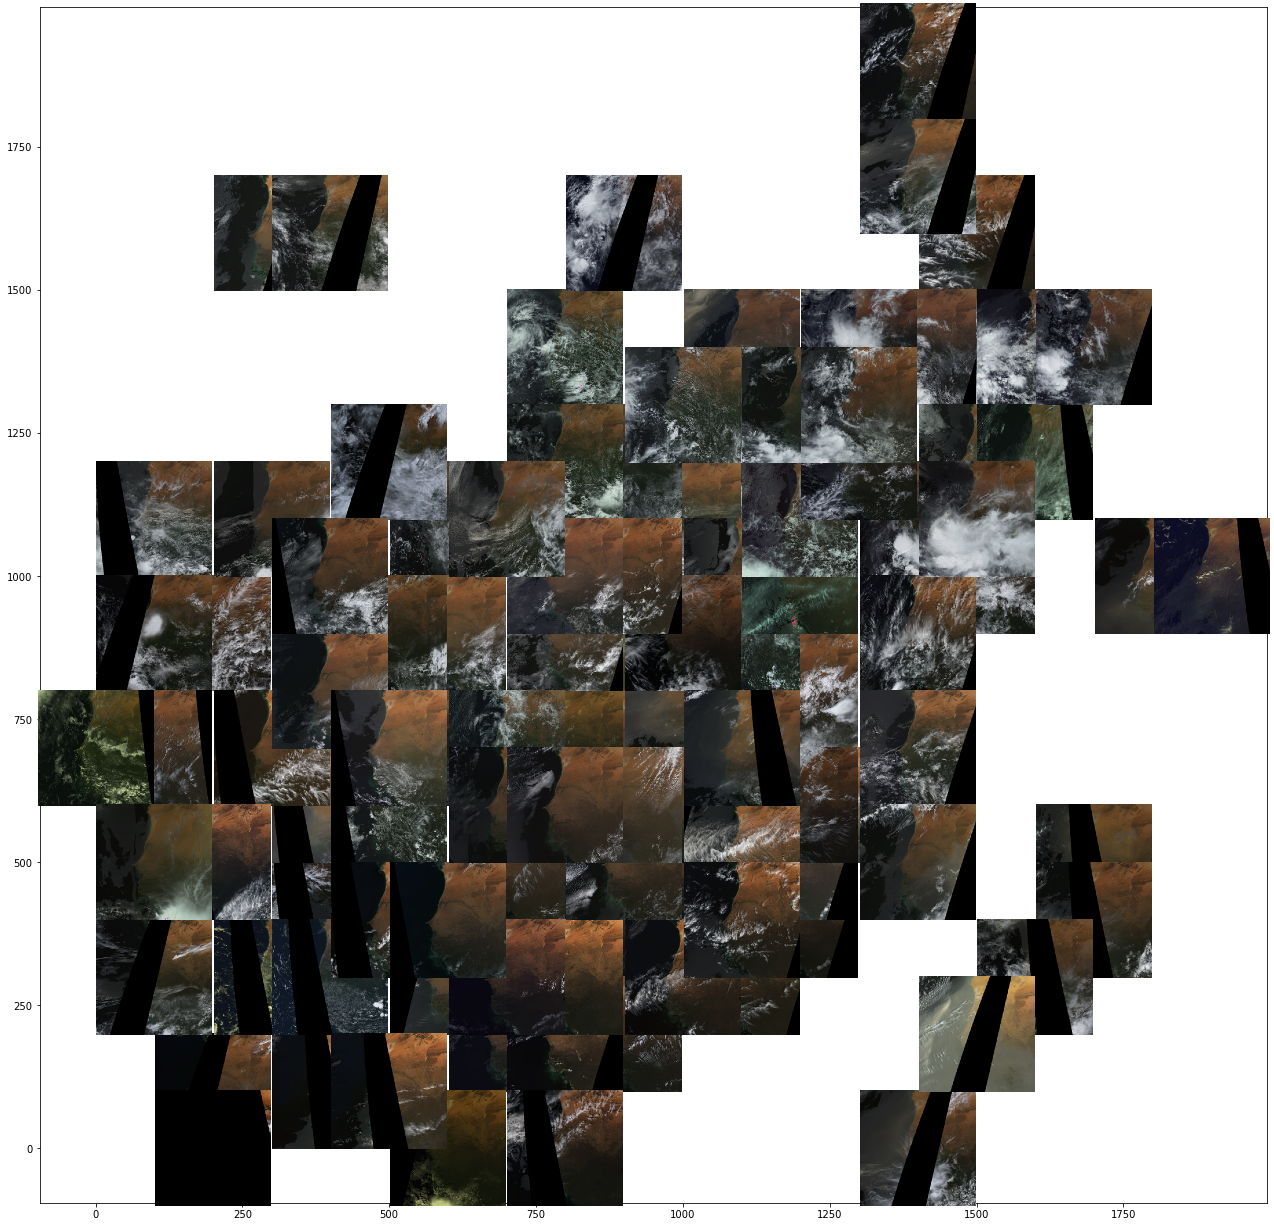

In [21]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)